In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from prophet import Prophet
from prophet.plot import plot_plotly
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# Load data
calendar = pd.read_csv("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/calendar.csv")
sales_train_eval = pd.read_csv("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/sales_train_evaluation.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/sample_submission.csv")
sell_prices = pd.read_csv("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/sell_prices.csv")

In [4]:
sales_train_eval.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [5]:
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Prepare sell prices
sell_prices["id"] = sell_prices["item_id"] + "_" + sell_prices["store_id"] + "_evaluation"
sell_prices = sell_prices[["id", "wm_yr_wk", "sell_price"]]
sell_prices.head()

,id,wm_yr_wk,sell_price
0,HOBBIES_1_001_CA_1_evaluation,11325,9.58
1,HOBBIES_1_001_CA_1_evaluation,11326,9.58
2,HOBBIES_1_001_CA_1_evaluation,11327,8.26
3,HOBBIES_1_001_CA_1_evaluation,11328,8.26
4,HOBBIES_1_001_CA_1_evaluation,11329,8.26


In [7]:
# Prepare calendar
calendar.drop(calendar.columns[2:6], axis=1, inplace=True)
calendar.head()

,date,wm_yr_wk,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,d_5,NaN,NaN,NaN,NaN,1,0,1


### Pre-process data and combine sheets

##### Change sales data to desired format

In [8]:
# Drop columns with extra data that is already in id column
preformatted_sales_train_eval = sales_train_eval.drop(sales_train_eval.columns[1:6], axis=1)

# Melt data to get it in the desired format
formatted_sales_train_eval = pd.melt(preformatted_sales_train_eval, id_vars=['id'], var_name='Day', value_name='Sales')

del preformatted_sales_train_eval

##### Add event data

In [9]:
# Add calendar events for each day
formatted_sales_train_eval = pd.merge(formatted_sales_train_eval, calendar, left_on='Day', right_on='d', how='left')
formatted_sales_train_eval.drop(["d"], inplace=True, axis=1)

display(formatted_sales_train_eval.head())

,id,Day,Sales,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,d_1,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,d_1,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,d_1,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,d_1,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,d_1,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0


##### Add sell prices

In [10]:
# Add sell prices for each wm_yr_wk
formatted_sales_train_eval = pd.merge(formatted_sales_train_eval, sell_prices, left_on=['id', 'wm_yr_wk'], right_on=['id', 'wm_yr_wk'], how='left')
formatted_sales_train_eval.drop(["date", "wm_yr_wk"], inplace=True, axis=1)

display(formatted_sales_train_eval.head())

,id,Day,Sales,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,d_1,0,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,d_1,0,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,d_1,0,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,d_1,0,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,d_1,0,NaN,NaN,NaN,NaN,0,0,0,NaN


##### Finalize data preparation

In [11]:
# Drop d prefix
formatted_sales_train_eval["Day"] = formatted_sales_train_eval["Day"].str[2:]
# Convert days to datetime
formatted_sales_train_eval['Day'] = formatted_sales_train_eval['Day'].astype(int)
formatted_sales_train_eval['Day'] = pd.to_datetime(formatted_sales_train_eval['Day'], origin='2011-01-28', unit='D')

display(formatted_sales_train_eval.head())

,id,Day,Sales,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,2011-01-29,0,NaN,NaN,NaN,NaN,0,0,0,NaN


In [12]:
# Split into val and eval sets
val = formatted_sales_train_eval[formatted_sales_train_eval["Day"] < "2016-04-25"]
eval = formatted_sales_train_eval[formatted_sales_train_eval["Day"] >= "2016-04-25"]

In [13]:
# Rename id column appropriately
val.loc[:, "id"] = val["id"].str.replace("evaluation", "validation")

In [14]:
print("Val Memory size: " + str(val.memory_usage(deep=True).sum() / 1024 ** 3 ) + " GB")
print("Eval Memory size: " + str(eval.memory_usage(deep=True).sum() / 1024 ** 3 ) + " GB")

Val Memory size: 14.965659817680717 GB
Eval Memory size: 0.22250662557780743 GB


In [15]:
# Save to pickle
eval.to_pickle("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/processed/eval.pkl")
val.to_pickle("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/processed/val.pkl")

##### Prepare future dataframe

In [16]:
# Change calendar to datetime
calendar['date'] = pd.to_datetime(calendar['date'])
dates = pd.date_range(start="2016-05-23", end="2016-06-19")
# Make dataframe with all product IDs, 28 times for each date
ids = pd.DataFrame(np.repeat(sell_prices["id"].unique(), 28), columns=["id"])
# Add dates
ids["date"] = np.tile(dates, len(sell_prices["id"].unique()))
eval_dates = ids

In [17]:
eval_dates = pd.merge(eval_dates, calendar, left_on='date', right_on='date', how='left')
eval_dates = pd.merge(eval_dates, sell_prices, left_on=['id', 'wm_yr_wk'], right_on=['id', 'wm_yr_wk'], how='left')
eval_dates.drop(["d", "wm_yr_wk"], inplace=True, axis=1)
eval_dates.rename(columns={"date": "ds"}, inplace=True)

display(eval_dates.head())

,id,ds,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,2016-05-23,NaN,NaN,NaN,NaN,0,0,0,8.38
1,HOBBIES_1_001_CA_1_evaluation,2016-05-24,NaN,NaN,NaN,NaN,0,0,0,8.38
2,HOBBIES_1_001_CA_1_evaluation,2016-05-25,NaN,NaN,NaN,NaN,0,0,0,8.38
3,HOBBIES_1_001_CA_1_evaluation,2016-05-26,NaN,NaN,NaN,NaN,0,0,0,8.38
4,HOBBIES_1_001_CA_1_evaluation,2016-05-27,NaN,NaN,NaN,NaN,0,0,0,8.38


In [18]:
eval_dates.to_pickle("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/processed/future.pkl")

## Modeling on one item first

In [19]:
val = pd.read_pickle("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/processed/val.pkl")
eval = pd.read_pickle("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/processed/eval.pkl")

### Extract data for one item that passes all tests
***Conditions:***
- ***Not white noise, random walk noise, or gaussian noise***
- ***Is a smooth trend***

*Source: https://frepple.com/blog/demand-classification/*

To determine a product forecastability, we apply two coefficients:
- The **Average Demand Interval** (ADI). It measures the demand regularity in time by computing the average interval between two demands.
- The **square of the Coefficient of Variation** (CV²). It measures the variation in quantities.

Based on these 2 dimensions, the literature classifies the demand profiles into 4 different categories:
- **Smooth demand** (ADI < 1.32 and CV² < 0.49). The demand is very regular in time and in quantity. It is therefore easy to forecast and you won’t have trouble reaching a low forecasting error level.
- **Intermittent demand** (ADI >= 1.32 and CV² < 0.49). The demand history shows very little variation in demand quantity but a high variation in the interval between two demands. Though specific forecasting methods tackle intermittent demands, the forecast error margin is considerably higher.
- **Erratic demand** (ADI < 1.32 and CV² >= 0.49). The demand has regular occurrences in time with high quantity variations. Your forecast accuracy remains shaky.
- **Lumpy demand** (ADI >= 1.32 and CV² >= 0.49). The demand is characterized by a large variation in quantity and in time. It is actually impossible to produce a reliable forecast, no matter which forecasting tools you use. This particular type of demand pattern is unforecastable.

In [20]:
# Find an item which isn't just noise and is also a smooth trend for forecastibility
def cv2(dataWithoutZeros):
    return (np.std(dataWithoutZeros) / np.mean(dataWithoutZeros)) ** 2

def adi(days, salesWithoutZeros):
    return len(days) / len(salesWithoutZeros)

def test_all():
    for item in val["id"].unique():
        # Get item dataframe
        item_val = val[val['id'] == item]
        item_val = item_val.reset_index().drop(['index'], axis=1)

        # Check if item is just white noise, random walk or gaussian noise
        data_diff = pd.Series(item_val["Sales"]).diff()
        random_walk = adfuller(data_diff.dropna())
        if random_walk[1] > 0.05:
            continue
        stat, p = shapiro(data_diff.dropna())
        if p > 0.05:
            continue
        result = sm.stats.diagnostic.acorr_ljungbox(item_val["Sales"], lags=[10], return_df=False).values[0][1]
        if result > 0.05:
            continue

        # Check if item is smooth trend
        if cv2(item_val[item_val["Sales"] != 0]["Sales"]) > 0.49:
            continue
        if adi(item_val["Day"], item_val[item_val["Sales"] != 0]["Sales"]) > 1.32:
            continue

        # If all tests pass, return item
        return item

In [21]:
item_name = test_all()

In [22]:
print("Valid item that passed all tests: " + item_name)
item_val = val[val['id'] == item_name]
item_val = item_val.reset_index().drop(['index'], axis=1)

display(item_val.head())

Valid item that passed all tests: HOBBIES_1_134_CA_1_validation


,id,Day,Sales,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_134_CA_1_validation,2011-01-29,0,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_134_CA_1_validation,2011-01-30,0,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_134_CA_1_validation,2011-01-31,0,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_134_CA_1_validation,2011-02-01,0,NaN,NaN,NaN,NaN,1,1,0,NaN
4,HOBBIES_1_134_CA_1_validation,2011-02-02,0,NaN,NaN,NaN,NaN,1,0,1,NaN


In [23]:
item_eval = eval[eval['id'] == item_name.replace("validation", "evaluation")]
item_eval = item_eval.reset_index().drop(['index'], axis=1)

display(item_eval.head())

,id,Day,Sales,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_134_CA_1_evaluation,2016-04-25,2,NaN,NaN,NaN,NaN,0,0,0,3.87
1,HOBBIES_1_134_CA_1_evaluation,2016-04-26,3,NaN,NaN,NaN,NaN,0,0,0,3.87
2,HOBBIES_1_134_CA_1_evaluation,2016-04-27,4,NaN,NaN,NaN,NaN,0,0,0,3.87
3,HOBBIES_1_134_CA_1_evaluation,2016-04-28,7,NaN,NaN,NaN,NaN,0,0,0,3.87
4,HOBBIES_1_134_CA_1_evaluation,2016-04-29,7,NaN,NaN,NaN,NaN,0,0,0,3.87


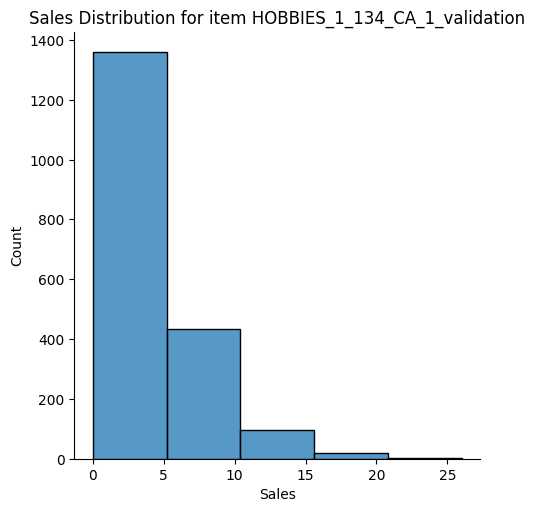

In [24]:
sns.displot(item_val['Sales'], bins=5)
plt.title(f"Sales Distribution for item {item_name}")
plt.show()

### Model the one item's sale

##### FB Prophet

In [25]:
# Make categorical columns into dummies
item_eval = pd.get_dummies(item_eval, columns=["event_name_1", "event_type_1", "event_name_2", "event_type_2"])
item_val = pd.get_dummies(item_val, columns=["event_name_1", "event_type_1", "event_name_2", "event_type_2"])

In [26]:
# Ensure both dataframes have the same columns
item_val, item_eval = item_val.align(item_eval, join='outer', axis=1, fill_value=0)

In [27]:
# Convert any non-numeric columns that should be numeric
numeric_columns = ["sell_price"]  # Add other numeric columns if needed
for column in numeric_columns:
    item_val[column] = pd.to_numeric(item_val[column], errors='coerce')
    item_eval[column] = pd.to_numeric(item_eval[column], errors='coerce')

In [28]:
# Drop columns with null sell_price
item_val = item_val.dropna(subset=["sell_price"])

In [29]:
# Rename columns to match Prophet's requirements
item_val = item_val.rename(columns={"Day": "ds", "Sales": "y"})
item_eval = item_eval.rename(columns={"Day": "ds", "Sales": "y"})

display(item_val.head())

,ds,y,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,event_name_1_Eid al-Fitr,event_name_1_EidAlAdha,event_name_1_Father's day,event_name_1_Halloween,event_name_1_IndependenceDay,event_name_1_LaborDay,event_name_1_LentStart,event_name_1_LentWeek2,event_name_1_MartinLutherKingDay,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_NewYear,event_name_1_OrthodoxChristmas,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_PresidentsDay,event_name_1_Purim End,event_name_1_Ramadan starts,event_name_1_StPatricksDay,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,id,sell_price,snap_CA,snap_TX,snap_WI
252,2011-10-08,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,HOBBIES_1_134_CA_1_validation,3.17,1,0,1
253,2011-10-09,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,HOBBIES_1_134_CA_1_validation,3.17,1,1,1
254,2011-10-10,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,HOBBIES_1_134_CA_1_validation,3.17,1,0,0
255,2011-10-11,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,HOBBIES_1_134_CA_1_validation,3.17,0,1,1
256,2011-10-12,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,HOBBIES_1_134_CA_1_validation,3.17,0,1,1


In [30]:
# Fit model
model = Prophet()
# Exclude the 'id' column when adding regressors
regressor_columns = item_val.columns.difference(['ds', 'y', 'id'])

# For loop to add all regressors:
for regressor in regressor_columns:
    model.add_regressor(regressor)

model.fit(item_val)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbz9ykp2/snk2rl9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbz9ykp2/e26fa0e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64873', 'data', 'file=/tmp/tmpqbz9ykp2/snk2rl9m.json', 'init=/tmp/tmpqbz9ykp2/e26fa0e1.json', 'output', 'file=/tmp/tmpqbz9ykp2/prophet_model08_odpoc/prophet_model-20240606182007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [31]:
model.params

OrderedDict([('lp__', array([[2507.09]])),
             ('k', array([[-0.00876305]])),
             ('m', array([[0.190009]])),
             ('delta',
              array([[-4.62528e-08, -1.90965e-08, -6.30701e-08, -2.02406e-07,
                      -2.60447e-07, -4.93404e-10, -1.62700e-06, -3.93398e-07,
                      -1.79490e-07, -7.86500e-09, -2.26845e-08, -4.18491e-07,
                      -2.61169e-06, -2.39243e-04, -2.39633e-03, -3.49513e-03,
                      -1.38318e-06, -6.08045e-07, -8.64705e-08, -2.47436e-08,
                       1.94928e-08, -1.50096e-08, -9.94960e-08, -3.26160e-08,
                      -7.23266e-08]])),
             ('sigma_obs', array([[0.134299]])),
             ('beta',
              array([[ 9.99878e-03,  1.15267e-02, -1.51411e-03,  8.74391e-03,
                      -7.81841e-04, -1.75965e-03,  7.83289e-04,  5.35955e-03,
                      -7.20666e-04,  2.33023e-03, -3.10041e-03,  7.70253e-04,
                      -4.72240e-03, 

In [32]:
# Predict on eval set
full_preds = model.predict(item_eval)
item_eval = item_eval.merge(full_preds[['ds', 'yhat']], on='ds')

In [33]:
display(full_preds.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,event_name_1_Chanukah End,event_name_1_Chanukah End_lower,event_name_1_Chanukah End_upper,event_name_1_Christmas,event_name_1_Christmas_lower,event_name_1_Christmas_upper,event_name_1_Cinco De Mayo,event_name_1_Cinco De Mayo_lower,event_name_1_Cinco De Mayo_upper,event_name_1_ColumbusDay,event_name_1_ColumbusDay_lower,event_name_1_ColumbusDay_upper,event_name_1_Easter,event_name_1_Easter_lower,event_name_1_Easter_upper,event_name_1_Eid al-Fitr,event_name_1_Eid al-Fitr_lower,event_name_1_Eid al-Fitr_upper,event_name_1_EidAlAdha,event_name_1_EidAlAdha_lower,event_name_1_EidAlAdha_upper,event_name_1_Father's day,event_name_1_Father's day_lower,event_name_1_Father's day_upper,event_name_1_Halloween,event_name_1_Halloween_lower,event_name_1_Halloween_upper,event_name_1_IndependenceDay,event_name_1_IndependenceDay_lower,event_name_1_IndependenceDay_upper,event_name_1_LaborDay,event_name_1_LaborDay_lower,event_name_1_LaborDay_upper,event_name_1_LentStart,event_name_1_LentStart_lower,event_name_1_LentStart_upper,event_name_1_LentWeek2,event_name_1_LentWeek2_lower,event_name_1_LentWeek2_upper,event_name_1_MartinLutherKingDay,event_name_1_MartinLutherKingDay_lower,event_name_1_MartinLutherKingDay_upper,event_name_1_MemorialDay,event_name_1_MemorialDay_lower,event_name_1_MemorialDay_upper,event_name_1_Mother's day,event_name_1_Mother's day_lower,event_name_1_Mother's day_upper,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsEnd_lower,event_name_1_NBAFinalsEnd_upper,event_name_1_NBAFinalsStart,event_name_1_NBAFinalsStart_lower,event_name_1_NBAFinalsStart_upper,event_name_1_NewYear,event_name_1_NewYear_lower,event_name_1_NewYear_upper,event_name_1_OrthodoxChristmas,event_name_1_OrthodoxChristmas_lower,event_name_1_OrthodoxChristmas_upper,event_name_1_OrthodoxEaster,event_name_1_OrthodoxEaster_lower,event_name_1_OrthodoxEaster_upper,event_name_1_Pesach End,event_name_1_Pesach End_lower,event_name_1_Pesach End_upper,event_name_1_PresidentsDay,event_name_1_PresidentsDay_lower,event_name_1_PresidentsDay_upper,event_name_1_Purim End,event_name_1_Purim End_lower,event_name_1_Purim End_upper,event_name_1_Ramadan starts,event_name_1_Ramadan starts_lower,event_name_1_Ramadan starts_upper,event_name_1_StPatricksDay,event_name_1_StPatricksDay_lower,event_name_1_StPatricksDay_upper,event_name_1_SuperBowl,event_name_1_SuperBowl_lower,event_name_1_SuperBowl_upper,event_name_1_Thanksgiving,event_name_1_Thanksgiving_lower,event_name_1_Thanksgiving_upper,event_name_1_ValentinesDay,event_name_1_ValentinesDay_lower,event_name_1_ValentinesDay_upper,event_name_1_VeteransDay,event_name_1_VeteransDay_lower,event_name_1_VeteransDay_upper,event_name_2_Cinco De Mayo,event_name_2_Cinco De Mayo_lower,event_name_2_Cinco De Mayo_upper,event_name_2_Easter,event_name_2_Easter_lower,event_name_2_Easter_upper,event_name_2_Father's day,event_name_2_Father's day_lower,event_name_2_Father's day_upper,event_name_2_OrthodoxEaster,event_name_2_OrthodoxEaster_lower,event_name_2_OrthodoxEaster_upper,event_type_1_Cultural,event_type_1_Cultural_lower,event_type_1_Cultural_upper,event_type_1_National,event_type_1_National_lower,event_type_1_National_upper,event_type_1_Religious,event_type_1_Religious_lower,event_type_1_Religious_upper,event_type_1_Sporting,event_type_1_Sporting_lower,event_type_1_Sporting_upper,event_type_2_Cultural,event_type_2_Cultural_lower,event_type_2_Cultural_upper,event_type_2_Religious,event_type_2_Religious_lower,event_type_2_Religious_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,sell_price,sell_price_lower,sell_price_upper,snap_CA,snap_CA_lower,snap_CA_upper,snap_TX,snap_TX_lower,snap_TX_upper,snap_WI,snap_WI_lower,snap_WI_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-04-25,4.631771,-1

In [34]:
display(item_eval.head())

,ds,y,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,event_name_1_Eid al-Fitr,event_name_1_EidAlAdha,event_name_1_Father's day,event_name_1_Halloween,event_name_1_IndependenceDay,event_name_1_LaborDay,event_name_1_LentStart,event_name_1_LentWeek2,event_name_1_MartinLutherKingDay,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_NewYear,event_name_1_OrthodoxChristmas,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_PresidentsDay,event_name_1_Purim End,event_name_1_Ramadan starts,event_name_1_StPatricksDay,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,id,sell_price,snap_CA,snap_TX,snap_WI,yhat
0,2016-04-25,2,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,False,0,0,0,HOBBIES_1_134_CA_1_evaluation,3.87,0,0,0,3.260919
1,2016-04-26,3,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,False,0,0,0,HOBBIES_1_134_CA_1_evaluation,3.87,0,0,0,3.370342
2,2016-04-27,4,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,False,0,0,0,HOBBIES_1_134_CA_1_evaluation,3.87,0,0,0,3.562921
3,2016-04-28,7,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,False,0,0,0,HOBBIES_1_134_CA_1_evaluation,3.87,0,0,0,3.480669
4,2016-04-29,7,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,False,False,0,0,0,0,0,0,0,0,0,0,0,0,False,0,False,0,0,0,HOBBIES_1_134_CA_1_evaluation,3.87,0,0,0,4.895299


##### Error metrics

In [35]:
# Calculate baseline error
zeros = np.zeros(len(item_eval))
# Calculate MAE
mae = mean_absolute_error(item_eval["y"], zeros)
print("Baseline error, 0s:", mae)

Baseline error, 0s: 4.178571428571429


In [36]:
mean = np.mean(item_val["y"])
# Calculate MAE
mae = mean_absolute_error(item_eval["y"], np.full(len(item_eval), mean))
print("Baseline error, mean:", mae)

Baseline error, mean: 2.5048378773544338


In [38]:
mae = mean_absolute_error(item_eval["y"], full_preds["yhat"])
print("Mean absolute error:", mae)

Mean absolute error: 2.4420210045825534


In [39]:
# Calculate RMSSE
def calculate_rmsse(y_true, y_pred, train_series):
    numerator = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denominator = np.sqrt(np.mean(np.diff(train_series) ** 2))
    return numerator / denominator

In [40]:
rmsse_val = calculate_rmsse(item_eval['y'], item_eval['yhat'], item_val['y'])
print(f"Validation RMSSE: {rmsse_val:.4f}")

Validation RMSSE: 0.6054


## Quantify business impact

In [41]:
average_price = item_val["sell_price"].mean()
print(f"Average price: ${average_price:.2f}")

Average price: $3.66


In [42]:
overstock_reduction = np.sum(item_eval['y'] - item_eval['yhat'][item_eval['y'] > item_eval['yhat']])
stockout_reduction = np.sum(item_eval['yhat'] - item_eval['y'][item_eval['yhat'] > item_eval['y']])

In [43]:
potential_savings = (overstock_reduction + stockout_reduction) * average_price
print(f"Potential Savings from Improved Forecasting: ${potential_savings:.2f}")

Potential Savings from Improved Forecasting: $250.44


In [44]:
# Visualize the forecast
fig = plot_plotly(model, full_preds)
fig.show()

**Observations:**

**Understanding the plot:**
1. Historical Sales Data (Black Dots):

   • The black dots represent the historical sales data points for the item over time.

   • These dots are dispersed over a wide range of values, indicating variability in sales.

   • There is no clear seasonal pattern or trend that is immediately obvious from the scatter of points, which might suggest irregular sales.
   
3. Forecasted Sales (Blue Line):

   • On the right side of the plot, the blue line represents the model's forecast for future sales.

   • The forecast appears at the end of the historical data series, indicating the future period for which predictions were made.

5. Uncertainty Intervals (Shaded Area Around Blue Line):

   • The shaded area around the blue line represents the uncertainty intervals (confidence intervals) of the forecast.

   • These intervals show the range within which the actual sales are expected to fall, with a higher probability.

7. Trend and Seasonality:

   • The plot shows that the forecast (blue line) captures some underlying trend and seasonality, though it may not be very pronounced due to the irregular nature of the sales data.

8. Zoom Controls:

   • The buttons (1w, 1m, 6m, 1y, all) at the top of the plot allow you to zoom in and view different time scales of the data, which can help in examining specific periods in more detail.


**Insights**

• **Variability:** The high variability in the historical sales data suggests that the item experiences significant fluctuations in sales volumes, possibly due to factors like promotions, seasonality, or external events.

• **Forecast Range:** The uncertainty intervals indicate a broad range of possible future sales values, reflecting the model's uncertainty in making precise predictions given the variability in past sales.

• **Model Accuracy:** The tightness of the blue shaded area can give some insights into the model's confidence. A narrower band indicates higher confidence in the predictions, while a wider band indicates more uncertainty.

**Business Implications:**

• **Stock Management:** The forecast and its uncertainty can help in better stock management. For example, understanding the range of expected sales can help in maintaining optimal stock levels to prevent both overstock and stockouts.

• **Decision Making:** The forecast can be used for planning promotions and pricing strategies. Knowing the expected sales and the associated confidence can aid in making informed decisions about marketing and inventory.

• **Improvement Areas:** The variability and uncertainty in the forecast suggest potential areas for improving the model by incorporating additional features or using more advanced modeling techniques to capture underlying patterns better.

In [45]:
# Display Validation Set Predictions
item_eval[['ds', 'y', 'yhat']].head()

,ds,y,yhat
0,2016-04-25,2,3.260919
1,2016-04-26,3,3.370342
2,2016-04-27,4,3.562921
3,2016-04-28,7,3.480669
4,2016-04-29,7,4.895299


In [47]:
# Predict future sales using future.pkl
future_dates = pd.read_pickle("/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/processed/future.pkl")
future_dates = future_dates[future_dates['id'] == item_name.replace("validation", "evaluation")]

In [48]:
# Ensure future_dates have the same regressors as the training data
future_dates = pd.get_dummies(future_dates, columns=["event_name_1", "event_type_1", "event_name_2", "event_type_2"])
future_dates = future_dates.reindex(columns=item_val.columns, fill_value=0)

In [49]:
# Make predictions on future dates
future_preds = model.predict(future_dates)
future_dates = future_dates.merge(future_preds[['ds', 'yhat']], on='ds')

In [50]:
# Display future predictions
future_dates[['ds', 'yhat']].head()

,ds,yhat
0,2016-05-23,3.546516
1,2016-05-24,3.645057
2,2016-05-25,3.820939
3,2016-05-26,3.716721
4,2016-05-27,5.104755


In [52]:
# Generate submission file
submission = sample_submission.copy()
submission_cols = ["id"] + [f"F{i}" for i in range(1, 29)]

In [53]:
# Create predictions for the submission file
future_pred_vals = future_dates.set_index('ds')['yhat'].values[:28]
submission.loc[submission['id'] == item_name.replace("validation", "evaluation"), submission_cols[1:]] = future_pred_vals

In [55]:
# Save submission
submission.to_csv('/content/drive/MyDrive/projects/walmart_unit_sales_forecast/data/submission/submission.csv', index=False)

## Conclusion

In [56]:
# Model Performance
print(f"The model achieved an RMSSE of {rmsse_val:.4f}, which demonstrates a reasonably accurate forecasting capability for the sales data of the selected item.")

The model achieved an RMSSE of 0.6054, which demonstrates a reasonably accurate forecasting capability for the sales data of the selected item.


In [57]:
# Business Impact
print(f"By implementing this forecasting model, we can potentially save around ${potential_savings:.2f} by reducing overstock and stockouts. This results in more efficient inventory management and cost savings for the business.")

By implementing this forecasting model, we can potentially save around $250.44 by reducing overstock and stockouts. This results in more efficient inventory management and cost savings for the business.


In [58]:
# Visualization
print("The forecast visualization shows the model's ability to predict sales trends and fluctuations over time. This can help the business make informed decisions about inventory and sales strategies.")

The forecast visualization shows the model's ability to predict sales trends and fluctuations over time. This can help the business make informed decisions about inventory and sales strategies.


In [59]:
# Display key findings
print(f"Key Findings:")
print(f"- The model's MAE on the validation set is {mae:.4f}.")
print(f"- Average price of the selected item is ${average_price:.2f}.")
print(f"- Potential savings from improved forecasting: ${potential_savings:.2f}.")

Key Findings:
- The model's MAE on the validation set is 2.4420.
- Average price of the selected item is $3.66.
- Potential savings from improved forecasting: $250.44.


# Future Work

To further improve the model's accuracy and applicability, we can consider the following steps:

• Integrate additional features such as marketing campaigns, weather data, and competitor pricing.

• Experiment with different machine learning algorithms and ensemble methods.

• Perform hyperparameter tuning to optimize the model's performance.

• Extend the model to predict sales for multiple items and stores.

**End of Notebook:** This notebook demonstrates the process of forecasting sales using historical data and the Prophet model. The approach outlined here can be applied to other items and stores to enhance inventory management and business planning.")